# example how to extract the WERN features for reference point collections in openEO
In this example we look on each step to generate a ML usable training dataset from given reference points.

In [1]:
from eo_processing.utils.mgrs import get_MGRSid10_center, tileID_2_epsg
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import geojson
import openeo
from openeo.extra.job_management import MultiBackendJobManager
from eo_processing.utils.helper import init_connection

### loading of the reference points CSV file as PANDAS dataframe
Note: this part has to be later adapted to be more adaptive to different input sources (GeoJSON, parquet files, STAC catalog, ...)

In [2]:
# Load the CSV file into a pandas dataframe
path_td = os.path.normpath(r'C:\Users\BUCHHORM\Downloads\SK_v5_reference-points_EUNIS2012_fixed.csv')
df = pd.read_csv(path_td)

### adding 10m GeoLocation identifier & cell center coordinates plus additional columns/checks
It is crucial that the reference data is in EPSG:4326 - identify the correct columns OR warp coordinates of other EPSG to EPSG:4326.

In [3]:
# first we add the unique MGRSid10 identifier and the corresponding center coordinates in EPSG:4326 for the 10m patch
df[['MGRSid10', 'center_lon', 'center_lat']] = df.apply(lambda row: get_MGRSid10_center(row['lon'], row['lat']), axis=1, result_type='expand')

In [4]:
# remove non-needed columns when exist
columns_to_remove = ['fid', 'entry', 'x', 'y']
df.drop(columns=[col for col in columns_to_remove if col in df.columns], inplace=True)

In [5]:
# Check and remove duplicate entries in the 'MGRSid10' column
if df['MGRSid10'].duplicated().any():
    duplicates = df[df['MGRSid10'].duplicated(keep=False)]
    print("Duplicate entries found in MGRSid10:")
    print(duplicates[['MGRSid10', 'lon', 'lat', 'center_lon', 'center_lat']])
    # Remove all entries with duplicate MGRSid10
    df = df[~df['MGRSid10'].duplicated(keep=False)]
    print("Duplicates have been removed.")
else:
    print("No duplicate entries in MGRSid10")

Duplicate entries found in MGRSid10:
            MGRSid10        lon        lat  center_lon  center_lat
324    34UCU58116788  19.081292  48.448086   19.081224   48.448101
325    34UCU58136787  19.081471  48.448019   19.081498   48.448016
326    34UCU58126789  19.081411  48.448215   19.081356   48.448193
327    34UCU58116784  19.081256  48.447704   19.081238   48.447741
328    34UCU58126789  19.081406  48.448226   19.081356   48.448193
...              ...        ...        ...         ...         ...
44731  33TXP78931371  17.396612  47.951694   17.396573   47.951731
44732  33TXP78941369  17.396760  47.951573   17.396699   47.951548
44733  33TXP78941369  17.396698  47.951554   17.396699   47.951548
44734  33TXP78891371  17.396035  47.951783   17.396038   47.951742
44735  33TXP78941369  17.396732  47.951563   17.396699   47.951548

[125 rows x 5 columns]
Duplicates have been removed.


In [6]:
# create a new column with the Sentinel-2 tileID
df['S2_tileID'] = df['MGRSid10'].astype(str).str[:5]

In [7]:
# reorder the columns just for better read
cols = df.columns.tolist()
new_order = ['MGRSid10', 'center_lon', 'center_lat', 'lon', 'lat', 'S2_tileID']
remaining_cols = [col for col in cols if col not in new_order]
df = df[new_order + remaining_cols]

### convert the DataFrame into a GeoPandas DataFrame with center point geometry

In [8]:
geometry = [Point(xy) for xy in zip(df.center_lon, df.center_lat)]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)
geo_df = geo_df.set_crs('epsg:4326')
print(f'Number of reference points: {len(geo_df)}')

Number of reference points: 45124


<Axes: >

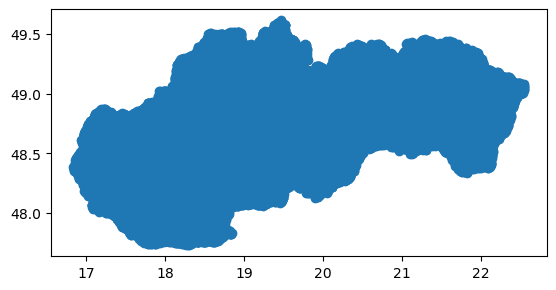

In [9]:
# just visualize for checks
geo_df.geometry.plot()

### split the geodataframe by 100kgrid into stand-alone dataframes for job operation
the 100kgrid represent the Sentinel-2 tileIDs. That is needed to avoid openEO limitations for extraction


In [10]:
split_jobs = [geo_df[geo_df['S2_tileID'] == tile_id] for tile_id in geo_df['S2_tileID'].unique()]
print(f'Number of jobs: {len(split_jobs)}')

Number of jobs: 21


In [11]:
# TODO: split S2_tile job further when more then x amount of points are in the job

<Axes: >

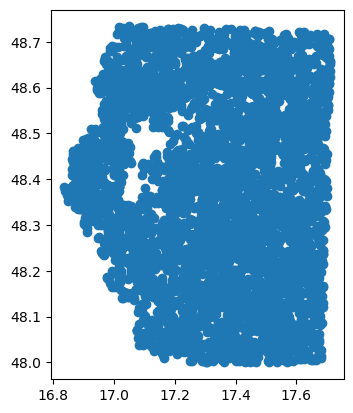

In [12]:
# for visualization we print all the points of one of the tiles (Sentinel-2 tileIDs)
split_jobs[0].geometry.plot()

### create the job dataframe with all info to run the openEO `MultiBackendJobManager` for the data extraction
For each job which has to run on openEO we need an extra row in a `pandas.DataFrame` which is handling all information needed by the JobManager to execute the `start_function`. The output dataframe should be savable as a .csv file. <br> <br>
Note: the full information of a sub-geodataframe of points/polygons can be saved into a row of a `pandas.DataFrame` by storing it in a row as string implementing the `geojson.FeatureCollection` interface. To convert the `geopandas.GeoDataFrame` into a string, simply use the `.to_json()` function.


In [13]:
def create_job_dataframe(split_jobs: list[gpd.GeoDataFrame], year: int, file_name_base: str) -> pd.DataFrame:
    """ Create a dataframe from the pre-split GeoDataFrame, containing all the necessary information to run the job.
    
    :param split_jobs: List of GeoDataFrames, each containing job information such as S2 tile ID and geometries.
    :param year: Year for which to create job entries. The start date will be January 1st of this year, and the end date will be January 1st of the following year.
    :param file_name_base: Base file name to be used, with the S2 tile ID appended to create unique file names for each job.
    :return: DataFrame containing job information, including the S2 tile ID, generated file name, start date, end date, and geometry as a JSON object.
    """
    
    columns = ['s2_tile', 'epsg', 'file_name', 'start_date', 'end_date', 'geometry']
    rows = []
    for job in split_jobs:
        # set master parameters
        start_date = f'{year}-01-01'
        end_date = f'{year+1}-01-01'
        s2_tile = job.S2_tileID.iloc[0]  # Job dataframes are split depending on the
        epsg = str(tileID_2_epsg(s2_tile))
        file_name = f'{file_name_base}_{s2_tile}.csv'
        
        rows.append(
            pd.Series(
                dict(zip(columns, [s2_tile, epsg, file_name, start_date, end_date, job[['MGRSid10', 'geometry']].to_json()]))
            )
        )

    return pd.DataFrame(rows)

In [14]:
job_df = create_job_dataframe(split_jobs, 2021, 'SK_v5_reference-points_EUNIS2012_features')

In [15]:
# add the number of points to handle in each S2 tile
def get_point_number(row: pd.Series) -> int:
    """
    :param row: A pandas Series object that contains a geometry field with a GeoJSON string.
    :return: The number of features present in the GeoJSON geometry.
    """
    return len(geojson.loads(row.geometry)['features'])

job_df['n_points'] = job_df.apply(get_point_number, axis=1)

In [16]:
job_df.head()

,s2_tile,epsg,file_name,start_date,end_date,geometry,n_points
0,33UXP,32633,SK_v5_reference-points_EUNIS2012_features_33UX...,2021-01-01,2022-01-01,"{""type"": ""FeatureCollection"", ""features"": [{""i...",4455
1,33UXQ,32633,SK_v5_reference-points_EUNIS2012_features_33UX...,2021-01-01,2022-01-01,"{""type"": ""FeatureCollection"", ""features"": [{""i...",577
2,33TXP,32633,SK_v5_reference-points_EUNIS2012_features_33TX...,2021-01-01,2022-01-01,"{""type"": ""FeatureCollection"", ""features"": [{""i...",363
3,33UYP,32633,SK_v5_reference-points_EUNIS2012_features_33UY...,2021-01-01,2022-01-01,"{""type"": ""FeatureCollection"", ""features"": [{""i...",1896
4,34UBU,32634,SK_v5_reference-points_EUNIS2012_features_34UB...,2021-01-01,2022-01-01,"{""type"": ""FeatureCollection"", ""features"": [{""i...",1878


### creating the job `start_job` function
The next step is to define a `start_job` function. This function will instruct the `MultiBackendJobManager` on how to initiate a new job on the selected backend. The `start_job` functionality should adhere to the following structure _start_job(row: pd.Series, connection: openeo.Connection, **kwargs)_. <br> <br>
NOTE: for simplification in this example we will only extract the DEM value from the CDSE collection.

In [17]:
def point_extraction(row: pd.Series, connection: openeo.Connection, provider: str , **kwgs) -> openeo.BatchJob:
    """Start a new job using the specified row out of the jobs DataFrame and connection."""
    
    # Get the variable parameters from the dataframe
    tileID = row["s2_tile"]
    start = row["start_date"]
    end = row["end_date"]
    file_name = row["file_name"]
    epsg = int(row["epsg"])
    
    #now we have to load the point geometries for all the points to process
    points_geometry = geojson.loads(row.geometry)
    assert isinstance(points_geometry, geojson.FeatureCollection)

    # Note: for points we do not define a spatial_extent in the collection at all AND run an aggregation_spatial with the GeoJSON FeatureCollection
    # Note2: for polygons we do not define a spatial_extent in the collection at all and later run a cube.filter_spatial(GeoJSON)
    datacube = connection.load_stac("https://stac.openeo.vito.be/collections/wenr_features")

    # reduce the temporal domain since copernicus_30 collection is "special"
    #datacube = datacube.reduce_dimension(dimension='t', reducer=lambda x: x.last(ignore_nodata=False))
    
    # resample the cube to 10m and EPSG corresponding Sentinel-2 tile
    datacube = datacube.resample_spatial(projection=epsg, resolution=10.0, method="near")
    
    # now we reduce the space to the needed point locations    
    datacube = datacube.aggregate_spatial(points_geometry, reducer="first")
    
    job = datacube.create_job(title=os.path.splitext(file_name)[0], 
                         description=f'WERN feature extraction for reference points in tile {tileID}', 
                         out_format='Parquet', 
                         filename_prefix=os.path.splitext(file_name)[0],
                         feature_id_property='MGRSid10'
                               )
    return job

### run the jobs

In [18]:
# define the output folder (make sure you adapt this to your folder structure)
test_num = 5
out_root = os.path.normpath(r'\\netapp03.vgt.vito.be\people_vol1\tests\openeo\point_extraction')
out_root = os.path.join(out_root, f'test_v{str(test_num)}')
os.makedirs(out_root, exist_ok=True)

In [19]:
# generate a unique name for the job tracker database (here: CSV file)
job_tracker = os.path.normpath(os.path.join(out_root, f'job_tracker_v{str(test_num)}.csv'))

In [20]:
# init of MultiBackendJobManager
manager = MultiBackendJobManager(root_dir=os.path.normpath(out_root), poll_sleep=15)

In [21]:
# create a connection to backend and add this active backend to the jobmanager
backend = 'cdse'  # also possible: cdse-stagging, terrascope, development, creodias, sentinelhub
connection = init_connection(backend)
manager.add_backend(backend, connection=connection, parallel_jobs=6)

Authenticated using refresh token.


In [22]:
# run the jobs stand-alone which blocks further usage of the Notebook up to all jobs are done
manager.run_jobs(df=job_df, start_job=point_extraction, job_db=job_tracker)

In [23]:
# add the costs to the tracker file
#todo

### combine the single results into one training data file
First load all the single parquet files of the jobs into `pandas.DataFrame` and combine.

In [23]:
# get the list of links to the job parquet files
df_tracker = pd.read_csv(job_tracker)
df_tracker['path_result'] = df_tracker['id'].apply(lambda x: os.path.normpath(os.path.join(out_root, f'job_{x}', 'timeseries.parquet')))
path_Results = df_tracker['path_result'].tolist()

In [26]:
for element in df_tracker[df_tracker['status'] == 'error'].id.tolist():
    print(f'job_{element}')

job_j-241025d9bdbc4a97b9508e9bda833439
job_j-241025a0332a4210912f9799f1108665
job_j-241025b9a34d4fe2af5a8c6b4a45d635
job_j-241025bd490b49fb8b2c0e972f9f4d20
job_j-241025dc495e438e853e07c3fc8920f6
job_j-241025c49fa7475b83e0c108efdeb369
job_j-2410253d55024f119894ea93f2121ae1
job_j-2410256d8aed41e88a912fa10887ffa6
job_j-24102554e907473da03867ddfef0d0bc
job_j-241025e3893b45559851ff86919f8418
job_j-2410255da8fa46b7acce1655930638ff
job_j-2410257d8b554610bbb2e7956b2e0201
job_j-2410251c603444c0a45b72cb4a0a543e
job_j-2410259e5a7740d0963ca62ec22a79a2


In [24]:
# read parquet files and combine
combined_df = pd.concat([pd.read_parquet(p) for p in path_Results], ignore_index=True)

FileNotFoundError: [Errno 2] No such file or directory: '\\\\netapp03.vgt.vito.be\\people_vol1\\tests\\openeo\\point_extraction\\test_v5\\job_j-241025d9bdbc4a97b9508e9bda833439\\timeseries.parquet'

In [26]:
# get a list of extracted feature names
feature_names = [x for x in combined_df.columns.tolist() if x not in geo_df.columns.tolist()]
# remove some openEO generated columns
feature_names = [x for x in feature_names if x not in ["date", "feature_index"]]

In [27]:
# run a check before merging row of results == row of input
assert len(combined_df) == len(geo_df)

In [28]:
# merge in results
combined_df = combined_df.set_index('MGRSid10')
geo_df = geo_df.set_index('MGRSid10')
result_df = geo_df.join(combined_df[feature_names], how='left').reset_index()

In [29]:
result_df.head()

,MGRSid10,center_lon,center_lat,lon,lat,S2_tileID,valid_L1,valid_L2,valid_L3,label_L1,label_L2,label_L3,geometry,DEM
0,33UXP57473908,17.118710,48.185468,17.118680,48.185489,33UXP,True,True,True,C,C3,C3.4,POINT (17.11871 48.18547),207.456100
1,33UXP59864327,17.152421,48.222541,17.152425,48.222568,33UXP,True,True,True,C,C3,C3.4,POINT (17.15242 48.22254),250.639648
2,33UXP63034439,17.195500,48.231803,17.195542,48.231791,33UXP,True,True,True,C,C3,C3.4,POINT (17.1955 48.2318),143.163879
3,33UXP62884673,17.194382,48.252879,17.194425,48.252869,33UXP,True,True,True,C,C3,C3.4,POINT (17.19438 48.25288),273.835571
4,33UXP63564713,17.203691,48.256300,17.203641,48.256284,33UXP,True,True,True,C,C3,C3.4,POINT (17.20369 48.2563),241.417328


In [30]:
# save to disk as GeoPackage
file_name = os.path.basename(path_td).replace('.csv', '_with-WERN-Features.gpkg')
path_gpkg = os.path.normpath(os.path.join(out_root, file_name))
result_df.to_file(path_gpkg, driver='GPKG')